## Import Libs

In [427]:
# Reset all variables so that we can 'run all cells' and not get unused variables hanging around
%reset -f

In [428]:
import pandas as pd
import numpy as np
import pytz

### Import Data

In [429]:
excel_file = 'data/Welder_LP_Tanzania_20180910-20180920.xlsx'
df_2min = pd.read_excel(excel_file, sheet_name='Welder_Tanzania LP')
df_2min = df_2min.rename(columns={'Timestamp (GMT)': 'time_gmt', 'Value': 'welder_count'})

# Convert date string to datetime so we can work with timezones
df_2min['time_gmt'] = pd.to_datetime(df_2min['time_gmt'])
df_2min.head()

,time_gmt,welder_count
0,2018-09-08 01:42:30,0
1,2018-09-08 01:44:30,0
2,2018-09-08 01:46:30,0
3,2018-09-08 01:48:30,0
4,2018-09-08 01:50:30,0


In [430]:
df_2min.shape

(9319, 2)

## Convert Timezones

In [431]:
# To see all timezones available (but select only the first 55 to see Africa): 
# pytz.all_timezones[0:55]  

In [432]:
# There was no Tanzania listed. Nairobi is +3 like Tanzania
# There should not be a problem with daylight savings time - neither observe it
tanzania_tz = pytz.timezone('Africa/Nairobi')

In [433]:
df_2min['time_local'] = df_2min['time_gmt'].dt.tz_localize('utc').dt.tz_convert(tanzania_tz)
df_2min.head()

,time_gmt,welder_count,time_local
0,2018-09-08 01:42:30,0,2018-09-08 04:42:30+03:00
1,2018-09-08 01:44:30,0,2018-09-08 04:44:30+03:00
2,2018-09-08 01:46:30,0,2018-09-08 04:46:30+03:00
3,2018-09-08 01:48:30,0,2018-09-08 04:48:30+03:00
4,2018-09-08 01:50:30,0,2018-09-08 04:50:30+03:00


## Filter out on/off welder noise

In [434]:
# If a welder_on_count value is less than 100, it's probably not actual usage. 
# Set anything less than a threshold to zero
noise_threshold = 100

In [435]:
df_2min['welder_is_on'] = np.where(df_2min['welder_count'] > noise_threshold, 1, 0 )
df_2min[60:70]

,time_gmt,welder_count,time_local,welder_is_on
60,2018-09-08 03:42:30,15,2018-09-08 06:42:30+03:00,0
61,2018-09-08 03:44:30,3,2018-09-08 06:44:30+03:00,0
62,2018-09-08 03:46:30,2,2018-09-08 06:46:30+03:00,0
63,2018-09-08 03:48:30,18,2018-09-08 06:48:30+03:00,0
64,2018-09-08 03:50:30,22,2018-09-08 06:50:30+03:00,0
65,2018-09-08 03:52:30,0,2018-09-08 06:52:30+03:00,0
66,2018-09-08 03:54:30,417,2018-09-08 06:54:30+03:00,1
67,2018-09-08 03:56:30,0,2018-09-08 06:56:30+03:00,0
68,2018-09-08 03:58:30,0,2018-09-08 06:58:30+03:00,0
69,2018-09-08 04:00:14,0,2018-09-08 07:00:14+03:00,0


In [436]:
df_2min[156:168]

,time_gmt,welder_count,time_local,welder_is_on
156,2018-09-08 06:54:14,0,2018-09-08 09:54:14+03:00,0
157,2018-09-08 06:56:14,0,2018-09-08 09:56:14+03:00,0
158,2018-09-08 06:58:14,0,2018-09-08 09:58:14+03:00,0
159,2018-09-08 07:00:14,0,2018-09-08 10:00:14+03:00,0
160,2018-09-08 07:02:14,0,2018-09-08 10:02:14+03:00,0
161,2018-09-08 07:04:14,311,2018-09-08 10:04:14+03:00,1
162,2018-09-08 07:06:14,2080,2018-09-08 10:06:14+03:00,1
163,2018-09-08 07:08:14,265,2018-09-08 10:08:14+03:00,1
164,2018-09-08 07:10:14,0,2018-09-08 10:10:14+03:00,0
165,2018-09-08 07:12:14,0,2018-09-08 10:12:14+03:00,0


## Utilization per interval

In [437]:
# Assume for any 2 minute logged interval that the actual utilization rate is 25%.
# In other words, in 2 minutes the welder is actually used for 30s.
# We will make this adjustable, along with the voltate and current in the app.
# But it doesn't hurt to hard-code it here - we can ignore it later. 
# Let's make the pattern "magnitude agnostic" so we can preserve the pattern, but apply 
# different voltage and current values to it

# For the welder, the energy load profile will be especially different from the peak power 
# consumed… so let's just make sure we remember that the kWh consumed in the 1-hour timestep 
# is in no way indicative of the peak power drawn during that hour. 
utilization_while_logged = 0.25

In [438]:
df_2min['welder_utilization'] = df_2min['welder_is_on'] * utilization_while_logged
df_2min[60:70]

,time_gmt,welder_count,time_local,welder_is_on,welder_utilization
60,2018-09-08 03:42:30,15,2018-09-08 06:42:30+03:00,0,0.00
61,2018-09-08 03:44:30,3,2018-09-08 06:44:30+03:00,0,0.00
62,2018-09-08 03:46:30,2,2018-09-08 06:46:30+03:00,0,0.00
63,2018-09-08 03:48:30,18,2018-09-08 06:48:30+03:00,0,0.00
64,2018-09-08 03:50:30,22,2018-09-08 06:50:30+03:00,0,0.00
65,2018-09-08 03:52:30,0,2018-09-08 06:52:30+03:00,0,0.00
66,2018-09-08 03:54:30,417,2018-09-08 06:54:30+03:00,1,0.25
67,2018-09-08 03:56:30,0,2018-09-08 06:56:30+03:00,0,0.00
68,2018-09-08 03:58:30,0,2018-09-08 06:58:30+03:00,0,0.00
69,2018-09-08 04:00:14,0,2018-09-08 07:00:14+03:00,0,0.00


## Resample 2-min intervals to hourly intevals
Here is a good example of how to resample time-series data: 
https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [446]:
# Convert the dataframe to have a datetime index (instead of a default integer) in order 
# to resample to hourly intervals
df_2min_index = df_2min.set_index('time_local')
df_2min_index[60:67]

,time_gmt,welder_count,welder_is_on,welder_utilization
time_local,,,,
2018-09-08 06:42:30+03:00,2018-09-08 03:42:30,15,0,0.00
2018-09-08 06:44:30+03:00,2018-09-08 03:44:30,3,0,0.00
2018-09-08 06:46:30+03:00,2018-09-08 03:46:30,2,0,0.00
2018-09-08 06:48:30+03:00,2018-09-08 03:48:30,18,0,0.00
2018-09-08 06:50:30+03:00,2018-09-08 03:50:30,22,0,0.00
2018-09-08 06:52:30+03:00,2018-09-08 03:52:30,0,0,0.00
2018-09-08 06:54:30+03:00,2018-09-08 03:54:30,417,1,0.25


In [452]:
# Examples of how to query data based on the new datetime index
# df_2min_index[df_2min_index.index.hour == 2]
# df_2min_index['2018-09-08']
# df_2min_index['2018-09-08':'2018-09-10']

# Every interval within an hour. We will reference this same hour
# later after resampling to show that the sum within the hour add up
df_2min_index['2018-09-08 09:00':'2018-09-08 09:58']

,time_gmt,welder_count,welder_is_on,welder_utilization
time_local,,,,
2018-09-08 09:00:14+03:00,2018-09-08 06:00:14,0,0,0.00
2018-09-08 09:02:14+03:00,2018-09-08 06:02:14,0,0,0.00
2018-09-08 09:04:14+03:00,2018-09-08 06:04:14,0,0,0.00
2018-09-08 09:06:14+03:00,2018-09-08 06:06:14,0,0,0.00
2018-09-08 09:08:14+03:00,2018-09-08 06:08:14,0,0,0.00
2018-09-08 09:10:14+03:00,2018-09-08 06:10:14,0,0,0.00
2018-09-08 09:12:14+03:00,2018-09-08 06:12:14,1755,1,0.25
2018-09-08 09:14:14+03:00,2018-09-08 06:14:14,3321,1,0.25
2018-09-08 09:16:14+03:00,2018-09-08 06:16:14,3016,1,0.25


In [464]:
# Sum every interval within an hour ('H')
df_hour = df_2min_index.resample('H').sum().drop(columns=['welder_count', 'welder_utilization'])

# The original data had 9319 rows. 
# There are 30 2-minute intervals in an hour.
# 9319 / 30 = 311, which is what the row count should show from .shape
df_hour.shape

(311, 1)

In [465]:
# You can see the welder_is_on count is consistent with this same hour range above
df_hour['2018-09-08 09:00':'2018-09-08 09:58']

,welder_is_on
time_local,
2018-09-08 09:00:00+03:00,8


## Representative Day of Weeks

In [466]:
df_mondays = df_hour[df_hour.index.weekday == 0]
df_mondays

,welder_is_on
time_local,
2018-09-10 00:00:00+03:00,0
2018-09-10 01:00:00+03:00,0
2018-09-10 02:00:00+03:00,0
2018-09-10 03:00:00+03:00,1
2018-09-10 04:00:00+03:00,0
2018-09-10 05:00:00+03:00,0
2018-09-10 06:00:00+03:00,0
2018-09-10 07:00:00+03:00,0
2018-09-10 08:00:00+03:00,0


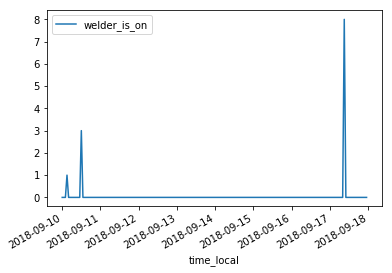

In [467]:
df_mondays.plot()